In [6]:
from transformers import (
    AutoTokenizer,
    AutoModel,
    PreTrainedModel,
    PreTrainedTokenizer,
)
import os
import time 
import json
import torch
import torch.nn as nn
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import Optional, List, Union, Any
from collections.abc import Mapping
from torch.optim import AdamW
from tqdm import tqdm
from dataclasses import dataclass, field

from transformers.trainer_pt_utils import get_parameter_names
from transformers.optimization import get_linear_schedule_with_warmup

# 配置参数
MODEL_DIR = "hfl/chinese-bert-wwm-ext"
DATA_DIR = "../data"
OUTPUT_DIR = "./output_data"
TASK_NAME = "KUAKE-QQR"
MAX_LENGTH = 64
BATCH_SIZE = 16
EPOCHS = 10
LABELS = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

@dataclass
class DataTrainingArguments:

    model_dir: str = field(
        default= MODEL_DIR,
        metadata={'help': 'The pretrained model directory'}
    )
    data_dir: str = field(
        default=DATA_DIR,
        metadata={'help': 'The data directory'}
    )
    max_length: int = field(
        default=MAX_LENGTH,
        metadata={'help': 'Maximum sequence length allowed to input'}
    )

    task_name: str = field(
        default=TASK_NAME,
        metadata={'help': 'The name of the task to train on'}
    )

    labels: int = field(
        default=LABELS,
        metadata={'help': 'The number of labels in the dataset'}
    )

    def __str__(self):
        self_as_dict = dataclasses.asdict(self)
        attrs_as_str = [f"{k}={v},\n" for k, v in sorted(self_as_dict.items())]
        return f"{self.__class__.__name__}(\n{''.join(attrs_as_str)})"
        
    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"

@dataclass
class TrainingArguments:

    output_dir: str = field(
        default='output_data/',
        metadata={'help': 'The output directory where the model predictions and checkpoints will be written.'}
    )
    train_batch_size: int = field(
        default=4,
        metadata={'help': 'batch size for training'}
    )
    eval_batch_size: int = field(
        default=1,
        metadata={'help': 'batch size for evaluation'}
    )
    gradient_accumulation_steps: int = field(
        default=1,
        metadata={'help': 'Number of updates steps to accumulate before performing a backward/update pass.'}
    )
    num_train_epochs: int = field(
        default=EPOCHS,
        metadata={"help": "The total number of training epochs"}
    )
    learning_rate: float = field(
        default=3e-5,
        metadata={'help': '"The initial learning rate for AdamW.'}
    )
    weight_decay: float = field(
        default=0.0,
        metadata={"help": "Weight decay for AdamW"}
    )
    warmup_ratio: float = field(
        default=0.05,
        metadata={"help": "Linear warmup over warmup_ratio fraction of total steps."}
    )
    dataloader_num_workers: int = field(
        default=0,
        metadata={"help": "Number of subprocesses to use for data loading (PyTorch only)"}
    )
    
    logging_steps: int = field(
        default=100,
        metadata={'help': 'logging states every X updates steps.'}
    )
    eval_steps: int = field(
        default=50,
        metadata={'help': 'Run an evaluation every X steps.'}
    )
    device: str = field(
        default= "cuda" if torch.cuda.is_available() else "cpu",
        metadata={"help": 'The device used for training'}
    )

    def get_warmup_steps(self, num_training_steps):
        return int(num_training_steps * self.warmup_ratio)

    def __str__(self):
        self_as_dict = dataclasses.asdict(self)
        attrs_as_str = [f"{k}={v},\n" for k, v in sorted(self_as_dict.items())]
        return f"{self.__class__.__name__}(\n{''.join(attrs_as_str)})"
        
    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(dataclasses.asdict(self), indent=2) + "\n"


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False

set_seed(42)

data_args = DataTrainingArguments(data_dir='../data')
train_args = TrainingArguments()
model_name = f'bert-{str(int(time.time()))}'
train_args.output_dir = os.path.join(train_args.output_dir, model_name)

tokenizer = AutoTokenizer.from_pretrained(data_args.model_dir)

In [62]:
import os
import json
from collections import defaultdict

def load_data(data_dir, task_name, argument = False):
    dir_path = os.path.join(data_dir, task_name)
    train_path = os.path.join(dir_path, f"{task_name}_train.json")
    dev_path = os.path.join(dir_path, f"{task_name}_dev.json")
    test_path = os.path.join(dir_path, f"{task_name}_test.json")

    def read_file(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            return json.load(f)

    def preprocess_train_dev(samples):
        grouped_data = defaultdict(lambda: [[], []])
        for sample in samples:
            label = sample.get("label", None)
            if label == "NA":
                continue
            try:
                label = int(label)
            except (ValueError, TypeError):
                continue
            query1 = sample["query1"]
            query2 = sample["query2"]
            grouped_data[query1][0].append(query2)
            grouped_data[query1][1].append(label)
        

        new_grouped_data = defaultdict(lambda: [[], []])
        if argument:
            for query, keys in grouped_data.items():
                key, label = keys
                key2, key1, key0 = [], [], []
                for i in range(len(label)):
                    if label[i] == 2:
                        key2.append(key[i])
                    elif label[i] == 1:
                        key1.append(key[i])
                    else:
                        key0.append(key[i])

                for i in range(len(key2)):
                    for j in range(i+1, len(key2)):
                        new_grouped_data[key2[i]][0].append(key2[j])
                        new_grouped_data[key2[i]][1].append(2)

                        new_grouped_data[key2[j]][0].append(key2[i])
                        new_grouped_data[key2[j]][1].append(2)
                    
                    for j in range(len(key1)):
                        new_grouped_data[key2[i]][0].append(key1[j])
                        new_grouped_data[key2[i]][1].append(1)

                        new_grouped_data[key1[j]][0].append(key2[i])
                        new_grouped_data[key1[j]][1].append(0)
                    
                    for j in range(len(key0)):
                        new_grouped_data[key2[i]][0].append(key0[j])
                        new_grouped_data[key2[i]][1].append(0)

            # if argument and query1 != query2:
            #     if label == 2:
            #         grouped_data[query2][0].append(query1)
            #         grouped_data[query2][1].append(2)
            #     elif label == 1:
            #         grouped_data[query2][0].append(query1)
            #         grouped_data[query2][1].append(0)
        grouped_data.update(new_grouped_data)
        for query1, keys in grouped_data.items():
            find_quary = False
            for quary2 in keys[0]:
                if quary2 == query1:
                    find_quary = True
                    break
            
            if not find_quary:
                keys[0].append(query1)
                keys[1].append(2)

        
        # 转换为列表形式
        processed_samples = [{
            "query": query1,
            "keys": keys[0],
            "label": keys[1]
        } for query1, keys in grouped_data.items()]
        return processed_samples

    def preprocess_test(samples):
        grouped_data = defaultdict(list)
        processed_samples = []
        for sample in samples:
            processed_samples.append({
                "query": sample["query1"],
                "keys": [sample["query2"]],
                "id": sample["id"]
            })
        return processed_samples

    def load_and_preprocess(file_path, is_test=False):
        data = read_file(file_path)
        if is_test:
            return preprocess_test(data)
        else:
            return preprocess_train_dev(data)

    return {
        "train": load_and_preprocess(train_path, is_test=False),
        "valid": load_and_preprocess(dev_path, is_test=False),
        "test": load_and_preprocess(test_path, is_test=True),
    }
# 示例调用
rawdata = load_data(data_args.data_dir, data_args.task_name)

In [63]:
# 示例调用
rawdata_argument = load_data(data_args.data_dir, data_args.task_name, argument=True)


In [64]:
print(len(rawdata["train"]), len(rawdata["valid"]), len(rawdata["test"]))
print(len(rawdata_argument["train"]), len(rawdata_argument["valid"]), len(rawdata_argument["test"]))

797 82 1596
6218 629 1596


In [3]:
data0 = rawdata["train"][0]
print(data0)

{'query': '天价输液费', 'keys': ['输液价格', '输液港费用', '出诊输液一般多少钱', '输液港价格', '输液贵吗', '输液要多少钱', '输液一般多少钱', '输液收费标准', '输液一次多少钱', '做一个输液港大概多少钱', '输液多少钱', '上门输液收费标准', '输一次液多少钱', '输液港多少钱', '打点滴贵吗', '一次性输液器多少钱一个', '一次性输液器多少钱', '打点滴一般多少钱', '天价输液费'], 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]}


In [5]:
tokenizer(data0["query"], data0["keys"][0], padding="max_length", max_length=64, return_tensors="pt")

{'input_ids': tensor([[ 101, 1921,  817, 6783, 3890, 6589,  102, 6783, 3890,  817, 3419,  102,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [14]:
class KUAKE_Dataset(Dataset):
    _id2label = ["0", "1", "2"]
    _label2id = {label: i for i, label in enumerate(_id2label)}
    
    def __init__(self, rawdata, tokenizer, max_length=64, type_="train"):
        self.rawdata = rawdata
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.type = type_
        self._data = self._process_data(rawdata)

    @classmethod
    def label2id(cls, label):
        return cls._label2id[label]
    
    @classmethod
    def id2label(cls, idx):
        return cls._id2label[idx]

    def _process_data(self, rawdata):
        data = []
        for item in rawdata:
            keys = item["keys"]
            query = item["query"]
            if self.type == "train" or self.type == "valid":
                input_ids = []
                attention_mask = []
                for key in keys:
                    tokens = self.tokenizer(
                            text = query,
                            text_pair = key,
                            padding='max_length',
                            truncation=True,
                            max_length=self.max_length,
                            return_tensors="pt"
                            )
                    input_ids.append(tokens["input_ids"].squeeze(0))
                    attention_mask.append(tokens["attention_mask"].squeeze(0))
                input_ids = torch.stack(input_ids, dim=0)
                attention_mask = torch.stack(attention_mask, dim=0)
                labels = torch.tensor(item["label"], dtype=torch.long)
                keys_num = len(keys)
                data.append({
                    "input_ids": input_ids,
                    "attention_mask": attention_mask,
                    "labels": labels,
                    'num': keys_num
                })
            elif self.type == "test":
                tokens = self.tokenizer(
                            text = query,
                            text_pair = keys[0],
                            padding='max_length',
                            truncation=True,
                            max_length=self.max_length,
                            return_tensors="pt"
                            )
                input_ids = tokens["input_ids"]
                attention_mask = tokens["attention_mask"]
                data.append({
                    "input_ids": input_ids,
                    "attention_mask": attention_mask,
                    'num': 1,
                    'id': item["id"],
                    'labels': None
                })
            else:
                raise ValueError("type must be 'train', 'valid' or 'test'")
        if self.type == "train":
            data = self.shuffle(data) 
        return data
    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        return self._data[idx]
    
    def shuffle(self,dataset):
        dataset = sorted(dataset, key=lambda x: x['num'])
        small_indices = [i for i, item in enumerate(dataset) if item['num'] < 10]
        random.shuffle(small_indices)
        large_indices = list(range(len(small_indices), len(dataset)))
        random.shuffle(large_indices)
        shuffle_indices = small_indices + large_indices
        dataset = [dataset[i] for i in shuffle_indices]
        return dataset

In [17]:
train_dataset = KUAKE_Dataset(rawdata["train"], tokenizer, max_length=data_args.max_length, type_='train')
valid_dataset = KUAKE_Dataset(rawdata["valid"], tokenizer, max_length=data_args.max_length, type_='valid')
test_dataset = KUAKE_Dataset(rawdata["test"], tokenizer, max_length=data_args.max_length, type_='test')

In [18]:
print(train_dataset[1]['input_ids'].shape)
print(train_dataset[1]['attention_mask'].shape)
print(train_dataset[1]['labels'].shape)
print(train_dataset[1]['num'])

torch.Size([8, 64])
torch.Size([8, 64])
torch.Size([8])
8


In [19]:
print(test_dataset[0]['input_ids'].shape)
print(test_dataset[0]['labels'])

torch.Size([1, 64])
None


train dataset length: 797
Max number of keys in train dataset: 21
Min number of keys in train dataset: 2


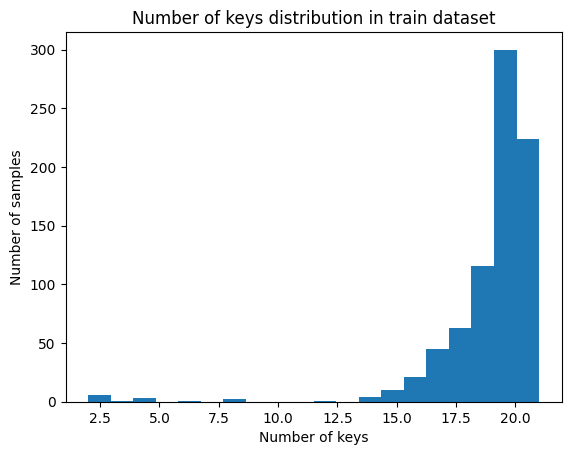

In [7]:
nums_train = [item['num'] for item in train_dataset]
print(f"train dataset length: {len(train_dataset)}")
# print(nums_train[:10])
print(f"Max number of keys in train dataset: {max(nums_train)}")
print(f"Min number of keys in train dataset: {min(nums_train)}")

from matplotlib import pyplot as plt
plt.hist(nums_train, bins=20)
plt.xlabel("Number of keys")
plt.ylabel("Number of samples")
plt.title("Number of keys distribution in train dataset")
plt.show()

In [41]:
@dataclass
class DataBatch:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor
    labels: torch.Tensor
    num: torch.Tensor
    batch: torch.Tensor
    id: Optional[Union[List[str], str]] = None

    def to(self, device):
        self.input_ids = self.input_ids.to(device)
        self.attention_mask = self.attention_mask.to(device)
        self.labels = self.labels.to(device) if self.labels is not None else None
        self.num = self.num.to(device)
        self.batch = self.batch.to(device)
        return self

def custom_collate_fn(data_batch):
    max_num_keys = max([item["num"] for item in data_batch])
    input_ids = []
    attention_mask = []
    all_labels = torch.tensor([], dtype=torch.long)
    nums = []
    increment = 0
    batch = torch.tensor([], dtype=torch.long)
    ids = []
    for i, sample in enumerate(data_batch):
        input_ids.append(sample["input_ids"])
        attention_mask.append(sample["attention_mask"])
        labels = sample["labels"]                # [num_keys]
        num_keys = sample["num"]
        increment += num_keys
        nums.append(increment)
        if labels is not None:
            all_labels = torch.cat([all_labels, labels])
        batch = torch.cat([batch, torch.ones(num_keys, dtype=torch.long) * i])

        if "id" in sample.keys():
            ids.append(sample["id"])
    
    # 将列表转为tensor
    input_ids = torch.cat(input_ids, dim=0) # [num_keys, max_length]
    attention_mask = torch.cat(attention_mask, dim=0) # [num_keys, max_length]
    all_labels = all_labels if len(all_labels) > 0 else None
    nums = torch.tensor(nums, dtype=torch.long) # [num_keys]
    
    # 返回CustomBatch实例
    return DataBatch(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=all_labels,
        num=nums,
        batch=batch,
        id=ids if len(ids) > 0 else None
    )


In [42]:
# 使用自定义的 collate_fn 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=train_args.train_batch_size, shuffle=False, collate_fn=custom_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=train_args.eval_batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=train_args.eval_batch_size, shuffle=False, collate_fn=custom_collate_fn)

In [35]:
# 测试一下
for data in train_loader:
    print(data.input_ids.shape)
    print(data.attention_mask.shape)
    print(data.labels)
    print(data.num)
    print(data.batch)
    print(data.id)
    break

torch.Size([16, 64])
torch.Size([16, 64])
tensor([0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2])
tensor([ 2, 10, 12, 16])
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3])
None


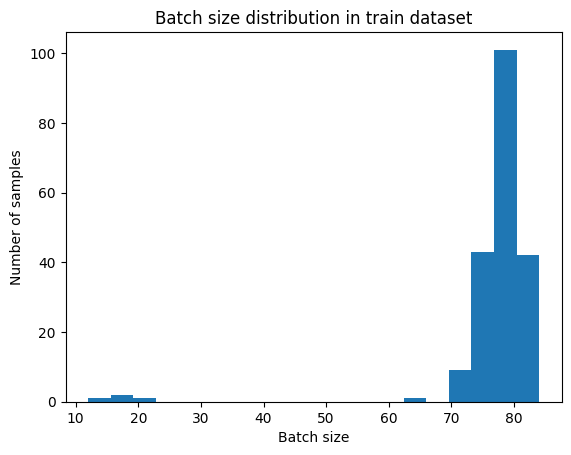

In [52]:
batch_size = [len(data.labels) for data in train_loader]

from matplotlib import pyplot as plt
plt.hist(batch_size, bins=20)
plt.xlabel("Batch size")
plt.ylabel("Number of samples")
plt.title("Batch size distribution in train dataset")
plt.show()


In [18]:
bert = AutoModel.from_pretrained(data_args.model_dir, num_labels=data_args.labels)

In [13]:
raw_traindata = rawdata["train"]

In [14]:
raw_traindata[0]

{'query': '天价输液费',
 'keys': ['输液价格',
  '输液港费用',
  '出诊输液一般多少钱',
  '输液港价格',
  '输液贵吗',
  '输液要多少钱',
  '输液一般多少钱',
  '输液收费标准',
  '输液一次多少钱',
  '做一个输液港大概多少钱',
  '输液多少钱',
  '上门输液收费标准',
  '输一次液多少钱',
  '输液港多少钱',
  '打点滴贵吗',
  '一次性输液器多少钱一个',
  '一次性输液器多少钱',
  '打点滴一般多少钱',
  '天价输液费'],
 'label': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]}

In [16]:
token = tokenizer(raw_traindata[0]["query"], raw_traindata[0]["keys"][0], padding='max_length', truncation=True, max_length=64, return_tensors="pt")
print(token)


{'input_ids': tensor([[ 101, 1921,  817, 6783, 3890, 6589,  102, 6783, 3890,  817, 3419,  102,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [20]:
output = bert(input_ids=token["input_ids"], attention_mask=token["attention_mask"])
print(output.last_hidden_state.shape)
print(output.pooler_output.shape)

torch.Size([1, 64, 768])
torch.Size([1, 768])


In [12]:
data = train_dataset[0]
print(data["query"][0].shape)
print(data["keys"][0].shape)
print(data["labels"].shape)

torch.Size([1, 64])
torch.Size([6, 64])
torch.Size([6])


In [ ]:
class LLM(nn.Module):
    def __init__(self, model_dir, num_labels):
        super(LLM, self).__init__()
        self.bert = AutoModel.from_pretrained(model_dir)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

In [46]:
class QKModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super(QKModel, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size*2, num_labels)
        )


    def forward(self, data):
        """
        Parameters
        ----------
        
        """
        input_ids = data.input_ids # [num_keys, max_length]
        attention_mask = data.attention_mask # [num_keys, max_length]

        outputs = self.encoder(input_ids, attention_mask) # [num_keys, max_length, hidden_size]
        pooled_output = outputs.pooler_output # [num_keys, hidden_size]
        logits = self.classifier(pooled_output) # [num_keys, num_labels]

        return logits
    
    def criterion(self):
        return nn.CrossEntropyLoss()

def create_optimizer_and_scheduler(
    args: TrainingArguments,
    model: nn.Module,
    num_training_steps: int,
):
    decay_parameters = get_parameter_names(model, [nn.LayerNorm])
    decay_parameters = [name for name in decay_parameters if "bias" not in name]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if n in decay_parameters],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
            "weight_decay": 0.0,
        },
    ]

    optimizer = AdamW(
        optimizer_grouped_parameters, 
        lr=args.learning_rate,
        weight_decay=args.weight_decay,
    )

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_training_steps=num_training_steps, 
        num_warmup_steps=args.get_warmup_steps(num_training_steps)
    )

    return optimizer, scheduler


In [48]:
def prepare_input(data: Union[torch.Tensor, Any], device: str = 'cuda'):
    """
    Prepares one `data` before feeding it to the model, be it a tensor or a nested list/dictionary of tensors.
    """
    if isinstance(data, Mapping):
        return type(data)({k: prepare_input(v, device) for k, v in data.items()})
    elif isinstance(data, (tuple, list)):
        return type(data)(prepare_input(v, device) for v in data)
    elif isinstance(data, torch.Tensor):
        kwargs = dict(device=device)
        return data.to(**kwargs)
    return data

def train(model, data, optimizer, scheduler, criterion, device):
    model.train()

    optimizer.zero_grad()
    data = data.to(device)
    labals = data.labels

    # 前向传播
    logits = model(data)
    nums = 0
    loss = criterion(logits, labals)
    correct = (torch.argmax(logits, dim=1) == labals).sum().item()
    correct /= len(labals)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()
    return loss.item(), correct

# 定义评估函数
def evaluate(model, dataloader, criterion, device):
    model.eval()
    eval_correct = 0
    eval_loss = 0.0
    with torch.no_grad():
        with tqdm(dataloader, desc="Evaluation", leave=False) as pbar:
            for data in dataloader:
                data = data.to(device)
                labels = data.labels
                # 前向传播
                logits = model(data)
                loss = criterion(logits, labels).item()
                correct = (torch.argmax(logits, dim=1) == labels).sum().item()
                eval_correct += correct/len(labels)
                eval_loss += loss   
                pbar.update(1)
                
    return eval_loss/len(dataloader), eval_correct/len(dataloader)

In [49]:
# 初始化模型
model = QKModel(data_args.model_dir, data_args.labels).to(train_args.device)

# 定义损失函数和优化器
criterion = model.criterion()
optimizer, scheduler = create_optimizer_and_scheduler(train_args, model, len(train_loader) * train_args.num_train_epochs)
# 开始训练
best_val_acc = 0.0
best_steps = 0
log_history = {
        "train_loss": [],
        "train_accuracy": [],
        "eval_loss": [],
        "eval_accuracy": []
    }

with tqdm(range(train_args.num_train_epochs* len(train_loader)), desc="Epochs") as epochs_pbar:
    global_steps = 0
    for epoch in range(train_args.num_train_epochs):
        epoch_loss= 0
        epoch_correct = 0
        epoch_total = 0
        val_loss = 0
        val_acc = 0
        for data in train_loader:
            global_steps += 1
            
            train_loss, train_acc = train(model, data, optimizer, scheduler, criterion, train_args.device)
            epoch_loss += train_loss
            epoch_correct += train_acc
            epoch_total += 1
            
            if (global_steps+1) % train_args.eval_steps == 0:
                val_loss, val_acc = evaluate(model, valid_loader, criterion, train_args.device)

                log_history["train_loss"].append(epoch_loss / epoch_total)
                log_history["train_accuracy"].append(epoch_correct / epoch_total)
                log_history["eval_loss"].append(val_loss)
                log_history["eval_accuracy"].append(val_acc)


                # 保存最佳模型
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_steps = epoch
                    os.makedirs(train_args.output_dir, exist_ok=True)
                    save_dir = os.path.join(train_args.output_dir, f"checkpoint-{epoch}")
                    os.makedirs(save_dir, exist_ok=True)
                    torch.save(model.state_dict(), os.path.join(save_dir, "model.pth"))
                    tokenizer.save_pretrained(save_directory=save_dir)
            
            epochs_pbar.set_postfix({
                "train loss": epoch_loss / epoch_total,
                "train acc": epoch_correct / epoch_total,
                "eval loss": val_loss,
                "eval acc": val_acc
            })
            epochs_pbar.update(1)
        
log_history_path = os.path.join(train_args.output_dir, 'log_history.json')
with open(log_history_path, 'w', encoding='utf-8') as f:
    json.dump(log_history, f, indent=2, ensure_ascii=False)

Epochs:   3%|▎         | 56/2000 [00:40<23:20,  1.39it/s, train loss=1.03, train acc=0.448, eval loss=0.919, eval acc=0.569]


KeyboardInterrupt: 

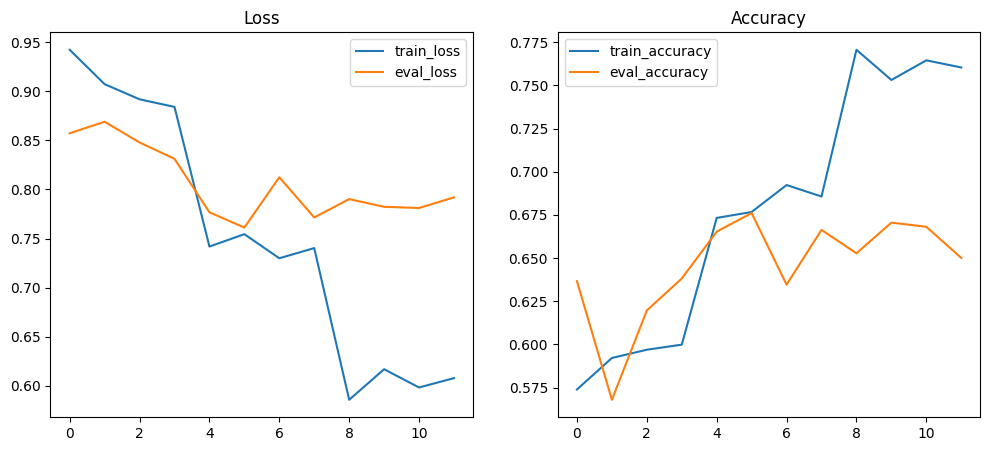

In [13]:

history = json.load(open(log_history_path, 'r', encoding='utf-8'))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(history['train_loss'], label='train_loss')
ax[0].plot(history['eval_loss'], label='eval_loss')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(history['train_accuracy'], label='train_accuracy')
ax[1].plot(history['eval_accuracy'], label='eval_accuracy')
ax[1].legend()
ax[1].set_title('Accuracy')


plt.show()

In [20]:

def predict(
    args: TrainingArguments,
    model: nn.Module,
    test_dataloader
):
    model.eval()
    preds_list = []
    with torch.no_grad():
        for item in test_dataloader:
            inputs = prepare_input(item, device=args.device)
            outputs = model(inputs)

            preds = torch.argmax(outputs.cpu(), dim=-1).numpy()
            preds_list.append(preds)

    print(f'Prediction Finished!')
    preds = np.concatenate(preds_list, axis=0).tolist()

    return preds

def generate_commit(output_dir, task_name, test_dataset, preds: List[int]):

    pred_test_examples = []
    for idx in range(len(test_dataset)):
        example = test_dataset[idx]
        label  = KUAKE_Dataset.id2label(preds[idx])
        # pred_example = {'id': example.guid, 'query1': example.text_a, 'query2': example.text_b, 'label': label}
        pred_example = {'id': example['id'], 'query1': example['query'], 'query2': example['keys'][0], 'label': label}
        pred_test_examples.append(pred_example)
    
    with open(os.path.join(output_dir, f'{task_name}_test.json'), 'w', encoding='utf-8') as f:
        json.dump(pred_test_examples, f, indent=2, ensure_ascii=False)

In [39]:
# 保存最终模型和tokenizer
model.load_state_dict(torch.load(os.path.join(train_args.output_dir, f"checkpoint-{best_steps}/model.pth"),weights_only=True))

model_save_path = os.path.join(train_args.output_dir, "final_model.pth")
torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(save_directory=train_args.output_dir)
print(f"Final model saved to {model_save_path} and tokenizer saved to {train_args.output_dir}")

preds = predict(train_args, model, test_loader)
generate_commit(train_args.output_dir, data_args.task_name, rawdata["test"], preds)
print(f"Commit file generated to {train_args.output_dir}")


Final model saved to output_data/bert-1734108269\final_model.pth and tokenizer saved to output_data/bert-1734108269
Prediction Finished!
Commit file generated to output_data/bert-1734108269
